In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np 
from scipy.integrate import quad
from math import *
from astropy.io import fits
import glob
import pylab 
from numpy.linalg import inv
import pandas as pd
from iminuit import Minuit, describe

In [2]:
# Physical constants
clight = 299792.458
H0 = 0.00007304 # Riess et al., 2022: H0 = 73.04 ± 1.04 km s−1 Mpc−1; Riess et al. 2016: H0 = 73.24 ± 1.74 km s−1 Mpc−1

m_step = 10.13
tau = 0.001

# Baseline parameters from JLA
omgM0 = 0.295   # = 0.295 +- 0.034
M_b0 = -19.05   # = −19.05 +- 0.02 
alpha0 = 0.141  #  alpha0         =    0.141 +- 0.006 
beta0 = 3.101   #  beta0          =    3.101 +- 0.075  
gamma0 = 0.     #  gamma0         =    0

# # Baseline parameters from Ancillary_G10.FITRES
# omgM0 = 0.298     # = 0.298 +- 0.022
# M_b0 = -19.3
# alpha0 = 0.15424  #  alpha0         =    0.15424 +-  0.00553   
# beta0 = 3.02371   #  beta0          =    3.02371 +-  0.06431   
# gamma0 = 0.05271  #  gamma0         =    0.05271 +-  0.00917 

# # Baseline parameters from Ancillary_С11.FITRES
# omgM0 = 0.298     # = 0.298 +- 0.022
# M_b0 = -19.3
# alpha0 = 0.15648  #  alpha0         =    0.15648 +-  0.00539  
# beta0 = 3.68895   #  beta0          =    3.68895 +-  0.08882    
# gamma0 = 0.05391  #  gamma0         =    0.05391 +-  0.00912

In [3]:
# Comoving radial coordinate (c not included) corresponding to redshift z = c int_0^z dz/H(z)
# in LambdaCDM flat model
def intfun(z, omgM):
    return 1/sqrt(omgM*(1 + z)**3 + (1 - omgM))

In [4]:
# Luminosity Distance function
def fitfundL(zcmb, omgM):
    mu = []
    for i in range (len(zcmb)): 
        zz = zcmb[i]
        mu.append(dL_z(zz, zz, omgM)) 
    return mu 

In [5]:
# Luminosity Distance corresponding to a redshift z
def dL_z(zcmb, zhel, omgM):
    mu_zz = 5*log10((1 + zhel)*clight*(quad(intfun, 0, zcmb, args=(omgM))[0] / (10*H0)))
    return mu_zz

In [6]:
# Distance modulus for the observational data, delta_b calculated from delta_{mb,x1,c}
def muexp(SNdata, M_b, alpha, beta, gamma, morph):
    mu=[]
    for i in range(len(SNdata['mB'])):
        delta_M = gamma / (1 + np.exp(-(SNdata['HOST_LOGMASS'].iloc[i]-m_step)/tau))
        delta_b = SNdata['biasCor_mB'].iloc[i] - beta*SNdata['biasCor_c'].iloc[i] + alpha*SNdata['biasCor_x1'].iloc[i]
        if SNdata['total_type'].iloc[i] in list_ET:
            mu.append(SNdata['mB'].iloc[i] - M_b + alpha*SNdata['x1'].iloc[i] - beta*SNdata['c'].iloc[i] + delta_M - delta_b + morph)
        else:
            mu.append(SNdata['mB'].iloc[i] - M_b + alpha*SNdata['x1'].iloc[i] - beta*SNdata['c'].iloc[i] + delta_M - delta_b)
    return mu

In [7]:
# Uncertainty on distance modulus for an observational data ???
def dmuexp(SNdata, alpha, beta):
    dmu=[]
    for i in range(len(SNdata['mB'])):
        dmu.append(sqrt(SNdata['mBERR'].iloc[i]**2+(alpha*SNdata['x1ERR'].iloc[i])**2+(beta*SNdata['cERR'].iloc[i])**2))
    return dmu

In [8]:
def outliers(data_pantheon):
    # Read LCs parameters for outlier supernovae (private communication with D. Scolnic)
    filename_outliers = '../data/FITOPT000.FITRES'
    data = pd.read_csv(filename_outliers, comment='#', skiprows=11, header=0, delimiter=r"\s+")

    data_name = data_pantheon.copy(deep=True)

    data.CID.duplicated().sum()
    SNoutliers = data[data.duplicated(subset=['CID'], keep=False)]

    SNoutliers['wt_mb'] = 1./SNoutliers['mBERR']**2
    SNoutliers['wt_x1'] = 1./SNoutliers['x1ERR']**2
    SNoutliers['wt_c'] = 1./SNoutliers['cERR']**2

### weighted mean

    grouped = SNoutliers.groupby(['CID'], as_index=False)

    def wavg_mb(group):
        d = group['mB']
        w = group['wt_mb']
        return (d * w).sum() / w.sum()
    
    def wavg_x1(group):
        d = group['x1']
        w = group['wt_x1']
        return (d * w).sum() / w.sum()
    
    def wavg_c(group):
        d = group['c']
        w = group['wt_c']
        return (d * w).sum() / w.sum()
    
    def wavg_mb_er(group):
        d = group['mB']
        w = group['wt_mb']
        err_w = np.sqrt(1 / w.sum())
        return err_w

    def wavg_x1_er(group):
        d = group['x1']
        w = group['wt_x1']
        err_w = np.sqrt(1 / w.sum())
        return err_w

    def wavg_c_er(group):
        d = group['c']
        w = group['wt_c']
        err_w = np.sqrt(1 / w.sum())
        return err_w

    df_mb = grouped.apply(wavg_mb)
    df_x1 = grouped.apply(wavg_x1)
    df_c = grouped.apply(wavg_c)

    df_mb_er = grouped.apply(wavg_mb_er)
    df_x1_er = grouped.apply(wavg_x1_er)
    df_c_er = grouped.apply(wavg_c_er)
    
    k = 0
    for i in df_mb['CID']:
        try:
            ind = data_name.loc[data_name['CID'] == i].index[0]
            data_name.loc[ind,'mB'] = df_mb[(df_mb['CID'] == i)].values[0][1]
            data_name.loc[ind,'x1'] = df_x1[(df_x1['CID'] == i)].values[0][1]
            data_name.loc[ind,'c'] = df_c[(df_c['CID'] == i)].values[0][1]
            
            data_name.loc[ind,'mBERR'] = df_mb_er[(df_mb_er['CID'] == i)].values[0][1]
            data_name.loc[ind,'x1ERR'] = df_x1_er[(df_x1_er['CID'] == i)].values[0][1]
            data_name.loc[ind,'cERR'] = df_c_er[(df_c_er['CID'] == i)].values[0][1]

            k = k + 1
            
        except Exception:
            continue
    return data_name

In [9]:
# Construct covariance matrix 
def mu_cov(filecov, SNdata, sig_int, alpha, beta, mask=False):

    SNcov = pd.read_csv(filecov, comment='#', header=None)
    Ndim = int(SNcov[0][0])
    
    Cmu = np.zeros(Ndim*Ndim)
    for i in range (len(SNcov)):
        if (i>0):
            Cmu[i-1] = SNcov[0][i]
    Cmu = Cmu.reshape(Ndim,Ndim)
    
    # Covarience matrix should have the same size as SN sample
    if mask:
        Cmu = Cmu[:,cut_sample]
        Cmu = Cmu[cut_sample]

  #add diagonal term
    sig_mu2 = SNdata['mBERR']**2 + (alpha*SNdata['x1ERR'])**2 + (beta*SNdata['cERR'])**2 + 2*(alpha*SNdata['COV_x1_x0']-beta*SNdata['COV_c_x0']-alpha*beta*SNdata['COV_x1_c'])
  #     sig_mass = 0.001 
    sig_z = (5 * np.sqrt(0.0008**2 + SNdata['zCMBERR']**2)) / (np.log(10.) * SNdata['zCMB'])
    sig_len = 0.055*SNdata['zCMB']
    sig_bias = SNdata['biasCorErr_mu']
    Cmu[np.diag_indices_from(Cmu)] += sig_mu2 + sig_z**2 + sig_len**2 + sig_int**2 + sig_bias**2 ## no sig_mass**2 (private communication with D. Scolnic)
    return Cmu

In [10]:
# Definition of chi2 fucntion for minimization
class Chi2:

    def __init__(self, SNdata): # Construct method
        '''Attributes'''
        self.chi2tot = 0.
        self.SNdata = SNdata
        self.dL = np.zeros(shape=(len(SNdata['zCMB']))) 
    
    def chi2(self, omgM, M_b, alpha, beta, gamma, morph):
        ''' Function that calculate the chi2 '''
        global Cinv
        len(Cinv)
        mu_z = muexp(self.SNdata, M_b, alpha, beta, gamma, morph)
        
        # Loop for matrix construction
        for i in range(len(self.SNdata['zCMB'])):
            zz = self.SNdata['zCMB'].iloc[i]
            zzz = self.SNdata['zHD'].iloc[i]
            self.dL[i] = dL_z(zz, zzz, omgM)
        
        # Contruction of the chi2 by matrix product
        result =  pylab.dot((mu_z-self.dL), pylab.dot((Cinv), (mu_z-self.dL)))
        self.chi2tot = result
        return result

In [13]:
#### CHANGE-- #####

### Read Pantheon data
# G10
# filename = '../data/Ancillary_G10.FITRES'
# filecov = '../data/sys_full_long_G10.txt'
# sig_int = 0.0900 # intrinsic uncertanty in G10
    
# C11
filename = '../data/Ancillary_C11.FITRES'
filecov = '../data/sys_full_long_C11.txt'
sig_int = 0.1092 # intrinsic uncertanty in C11
   
Npar = 4 # number of fit parameters

mask=True

#### --CHANGE #####

data = pd.read_csv(filename, comment='#', skiprows=6, header=0, delimiter=r"\s+")  
data_outl = outliers(data)

file_morph = '../data/host_data.dat'
SNdata_host = pd.read_csv(file_morph,  sep=',', usecols=['CID','total_type'])


SNdata = pd.merge(data_outl, SNdata_host, on='CID')


list_ET = ['Early-type', 'Pa', 'E', 'E/S0', 'S0', 'S0/a']
list_LT = ['Sa', 'Sab', 'Sb', 'Sbc', 'Sc', 'Scd', 'Sd', 'Ir', 'SF', 'Late-type', 'Sb/Sbc/Sc', 'Scd/Ir']

ET = SNdata['total_type'].isin(list_ET)
LT = SNdata['total_type'].isin(list_LT)

ALL = SNdata['total_type'].isin(list_ET+list_LT)

#### CHANGE-- #####

SNdata = SNdata[ALL] # if no mask, them comment line
cut_sample = ALL

#### --CHANGE #####

a, k = [], 0
cut = 0.001 # criteria for fit quality

while True:   
    if k == 0:
        alpha_matrix, beta_matrix = alpha0, beta0
    else:
        alpha_matrix, beta_matrix = alpha_res, beta_res

    # Global variables

    Cmat = mu_cov(filecov, SNdata, sig_int, alpha_matrix, beta_matrix, mask=mask)
    Cinv = inv(Cmat)  

    
    # Perform SN fit
    chi2function = Chi2(SNdata)
    m = Minuit(chi2function.chi2, omgM=omgM0, M_b=M_b0, alpha=alpha0, beta=beta0, gamma=0.00001, morph=0.00001)
    
    m.limits = [(0.2,0.4), (-20.,-18.), (0.1,0.2), (2.,4), (0,0.1), (-0.1,0.1)]
    m.fixed = [True, False, False, False, False, False]
    m.migrad()
    #m.hesse
    
    # Extract fitted parameters
    omgM_res, M_b_res, alpha_res, beta_res, gamma_res, morph_res = list(m.values)
#     domgM, dM_b, dalpha, dbeta, dgamma = list(m.errors) # check that these are errors indeed
    chi2ndf = chi2function.chi2(omgM_res, M_b_res, alpha_res, beta_res, gamma_res, morph_res) / (len(SNdata['mB']) - Npar)
        
    a.append(list(m.values))

    print(m.values, m.errors)
    print('chi2ndf = ', chi2ndf, ', N iteration = ', k+1)
    
    if k > 0:
        if abs(a[k][0] - a[k-1][0])/a[k-1][0] < cut and abs(a[k][1] - a[k-1][1])/a[k-1][1] < cut and abs(a[k][2] - a[k-1][2])/a[k-1][2] < cut and abs(a[k][3] - a[k-1][3])/a[k-1][3] < cut and abs(a[k][4] - a[k-1][4])/a[k-1][4] < cut:
            break    
    k += 1

/var/folders/kp/fd4m_8b97sj5zxmtkc3cd4n00000gn/T/ipykernel_76172/1136878796.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNoutliers['wt_mb'] = 1./SNoutliers['mBERR']**2
/var/folders/kp/fd4m_8b97sj5zxmtkc3cd4n00000gn/T/ipykernel_76172/1136878796.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNoutliers['wt_x1'] = 1./SNoutliers['x1ERR']**2
/var/folders/kp/fd4m_8b97sj5zxmtkc3cd4n00000gn/T/ipykernel_76172/1136878796.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

<ValueView omgM=0.295 M_b=-19.165341817692813 alpha=0.16389431059828086 beta=3.6123241008698646 gamma=0.09999999799663854 morph=0.0402267755688072> <ErrorView omgM=0.00295 M_b=0.011905834751694044 alpha=0.009703456353558917 beta=0.1534028923174544 gamma=0.0854128281990517 morph=0.021037045707195633>
chi2ndf =  0.6566977329948459 , N iteration =  1


/var/folders/kp/fd4m_8b97sj5zxmtkc3cd4n00000gn/T/ipykernel_76172/3072217659.py:5: RuntimeWarning: overflow encountered in exp
  delta_M = gamma / (1 + np.exp(-(SNdata['HOST_LOGMASS'].iloc[i]-m_step)/tau))


<ValueView omgM=0.295 M_b=-19.16543183778158 alpha=0.16280471215551298 beta=3.6446516582649564 gamma=0.09999999743995619 morph=0.038825854752044316> <ErrorView omgM=0.00295 M_b=0.012554919203772386 alpha=0.010291885684352783 beta=0.1609132726649669 gamma=0.08540143874322462 morph=0.022447811013161227>
chi2ndf =  0.5857795090655316 , N iteration =  2


/var/folders/kp/fd4m_8b97sj5zxmtkc3cd4n00000gn/T/ipykernel_76172/3072217659.py:5: RuntimeWarning: overflow encountered in exp
  delta_M = gamma / (1 + np.exp(-(SNdata['HOST_LOGMASS'].iloc[i]-m_step)/tau))


<ValueView omgM=0.295 M_b=-19.165467944260417 alpha=0.1628076950164097 beta=3.644618807319568 gamma=0.09999999743523436 morph=0.03876788784384539> <ErrorView omgM=0.00295 M_b=0.012590303888272203 alpha=0.010321826222432579 beta=0.16139943612310992 gamma=0.08540139205273958 morph=0.02251361224447025>
chi2ndf =  0.5818204067233858 , N iteration =  3


In [12]:
# Experimental distance modulus
SNdata['mu_exp'] = muexp(SNdata, M_b_res, alpha_res, beta_res, gamma_res)
mu_exp = SNdata['mu_exp']
SNdata['dmu_exp'] = dmuexp(SNdata, alpha_res, beta_res)
dmu_exp = SNdata['dmu_exp']

zcmb = SNdata['zCMB']

# Theoretical distance modulus (LambdaCDM)
SNdata['mu_th'] = fitfundL(zcmb, omgM_res)
mu_th = SNdata['mu_th']

# Residual = experimental - theoretical
mu_res = []
dmu_res = []
for i in range(len(mu_exp)):
    mu_res.append(mu_exp[i] - mu_th[i])
    dmu_res.append(dmu_exp[i])
SNdata['res'] = mu_res
res = SNdata['res']
SNdata['dres'] = dmu_res
dres = SNdata['dres']
    
# Theoretical curve (LambdaCDM)
xfunc = np.linspace(0.001, 2.5, 1000)
yfunc = np.zeros(len(xfunc))
yfunc = fitfundL(xfunc, omgM_res)

x0 = np.linspace(0.001, 2.5, 1000)
y0 = np.zeros(len(x0))
 
str0 = '{0:10s} {1:2.3f} \n'.format(r'$\chi^2_{/ndf}$ = ', chi2ndf)
str1 = '{0:10s} {1:2.3f} {2:4s} {3:2.3f} \n'.format(r'$\Omega_m$ =', omgM_res, r' $\pm$ ', domgM)
str2 = '{0:10s} {1:4.2f} {2:4s} {3:4.2f} \n'.format(r'$M_B$ = ', M_b_res, r' $\pm$ ', dM_b)
str3 = '{0:10s} {1:2.3f} {2:4s} {3:2.3f} \n'.format(r'$\alpha$ = ', alpha_res, r' $\pm$ ', dalpha)
str4 = '{0:10s} {1:3.2f} {2:4s} {3:3.2f} \n'.format(r'$\beta$ = ', beta_res, r' $\pm$ ', dbeta)
str5 = '{0:10s} {1:2.3f} {2:4s} {3:2.3f} \n'.format(r'$\gamma$ = ', gamma_res, r' $\pm$ ', dgamma)
str_fit = '{} {} {} {} {} {}'.format(str0, str1, str2, str3, str4, str5)

setNBandHST = SNdata['IDSAMPLE']==0
setSDSS = SNdata['IDSAMPLE']==2
setSNLS = SNdata['IDSAMPLE']==3
setPS1 = SNdata['IDSAMPLE']==1
setHST = SNdata['IDSAMPLE']==4

fig = plt.figure(figsize=[8,8])
P1, P2 = fig.subplots(2, 1, sharex=True, sharey=False, gridspec_kw=dict(height_ratios=[3,1]))
fig.subplots_adjust(hspace=0)
P1.errorbar(zcmb, mu_exp, yerr=dmu_exp, marker='.', color="orange", linestyle="None", 
            ecolor="orange", label='Low and high-z')
P1.errorbar(zcmb[setSDSS], mu_exp[setSDSS], yerr=dmu_exp[setSDSS], marker='.', color="green", linestyle="None", 
            ecolor="green", label='SDSS')
P1.errorbar(zcmb[setSNLS], mu_exp[setSNLS], yerr=dmu_exp[setSNLS], marker='.', color="red", linestyle="None", 
            ecolor="red", label='SNLS')
P1.errorbar(zcmb[setPS1], mu_exp[setPS1], yerr=dmu_exp[setPS1], marker='.', color="blue", linestyle="None", 
            ecolor="blue", label='PS1')

P1.plot(xfunc, yfunc, c="grey", label="$\Lambda$CDM fit")
P1.set_xlabel('Redshift z')
P1.set_ylabel(r'Distance modulus $\mu = m_B - M_B + \alpha x_1 - \beta c + \Delta_M$')  
P1.set_xscale('log')
P1.set_xlim(5e-3, 2.3)
P1.set_ylim(30, 48)
P1.text(0.2, 31, str_fit, fontsize=12)
P1.legend(loc='best', shadow=True, fontsize='x-large')

P2.errorbar(zcmb, res, yerr=dres, marker='.', color="orange", linestyle="None", 
            ecolor="orange")
P2.errorbar(zcmb[setSDSS], res[setSDSS], yerr=dres[setSDSS], marker='.', color="green", linestyle="None", 
            ecolor="green")
P2.errorbar(zcmb[setSNLS], res[setSNLS], yerr=dres[setSNLS], marker='.', color="red", linestyle="None", 
            ecolor="red")
P2.errorbar(zcmb[setPS1], res[setPS1], yerr=dres[setPS1], marker='.', color="blue", linestyle="None", 
            ecolor="blue")
P2.plot(x0, y0, c="grey", label="$\Lambda$CDM fit")

# P1.plot(zcmb, SNdata['MU'], color="black", marker='+', linestyle="None", label='Pantheon data')
# P2.plot(zcmb, SNdata['MURES'], marker='o', color="green", linestyle="None")

P2.set_xlabel('Redshift z')
P2.set_ylabel(r'$\mu - \mu_{\Lambda CDM}$')  
P2.set_xscale('log')
P2.set_xlim(5e-3, 2.5)
P2.set_ylim(-1.3, 1)

/var/folders/kp/fd4m_8b97sj5zxmtkc3cd4n00000gn/T/ipykernel_70199/3159529448.py:5: RuntimeWarning: overflow encountered in exp
  delta_M = gamma / (1 + np.exp(-(SNdata['HOST_LOGMASS'].iloc[i]-m_step)/tau))


KeyError: 0

<IPython.core.display.Javascript object>


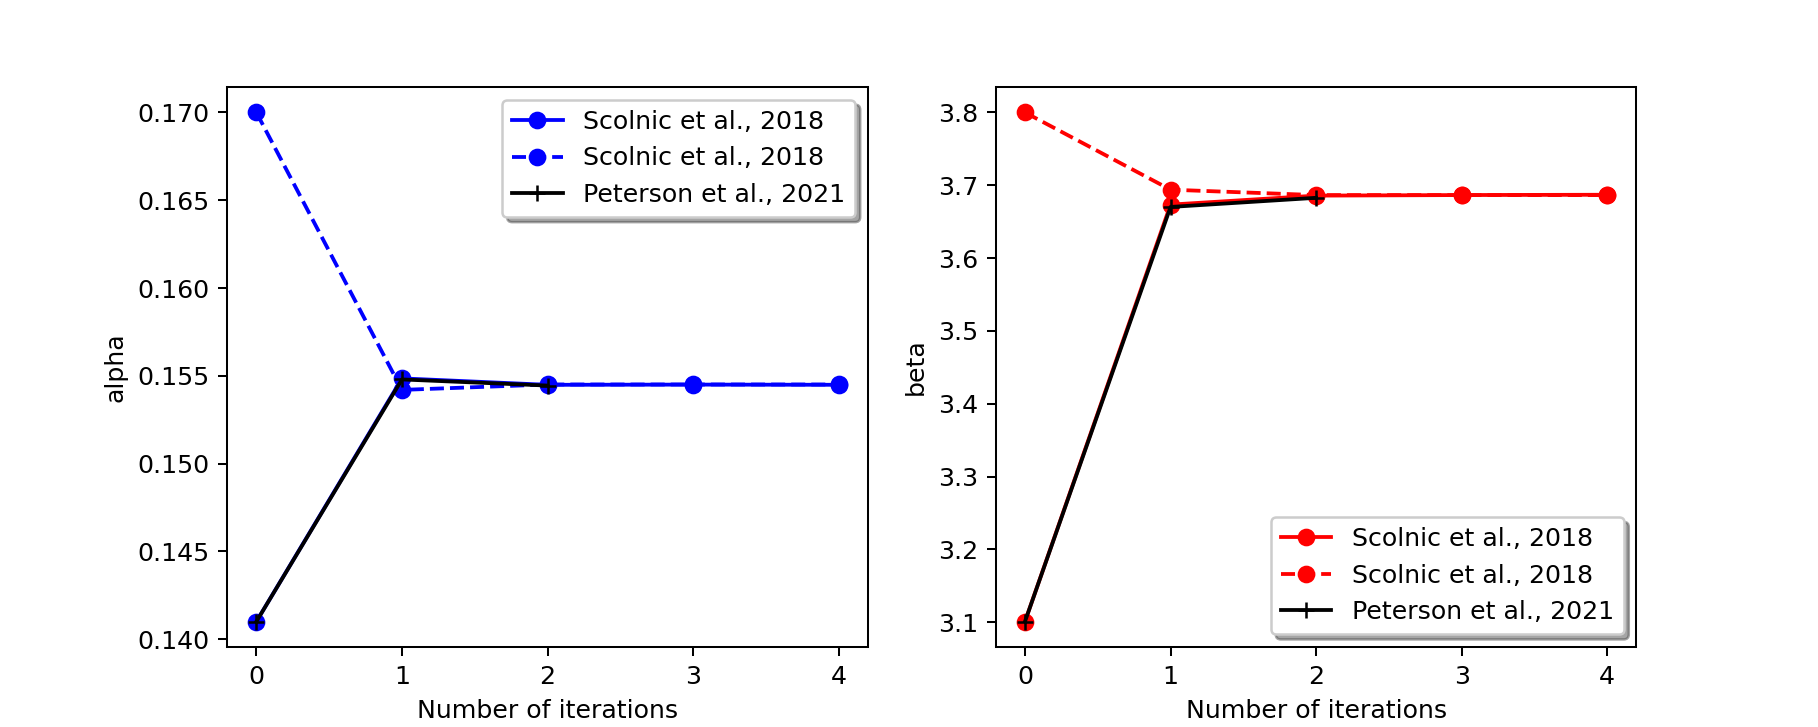

In [13]:
# Convergence of HD fit
it_num = [0, 1, 2, 3, 4]
it_num_new_eq = [0, 1, 2]

alpha_jla = [0.141, 0.1548509682867611, 0.15448439469849296, 0.1544974159619954, 0.15448584736381002]
beta_jla = [3.101, 3.673462780229306, 3.685813625816902, 3.686595019112068, 3.6870023682038306]

alpha_rand = [0.17, 0.15419551429872608, 0.1545046260168899, 0.15450372491968595, 0.15450375183261658]
beta_rand = [3.8, 3.693960806824087, 3.6865451482599223, 3.6865145576022287, 3.686513819776445]

alpha_new_eq = [0.141, 0.15479178271210872, 0.15444209443198997]
beta_new_eq = [3.101, 3.670265615203548, 3.682804903560677]

fig = plt.figure(figsize=[10,4])
ax1  = fig.add_subplot(121)
ax2  = fig.add_subplot(122)

ax1.plot(it_num, alpha_jla, 'b-o', it_num, alpha_rand, 'b--o', label = 'Scolnic et al., 2018')
ax1.plot(it_num_new_eq, alpha_new_eq, 'k-+', label = 'Peterson et al., 2021')
ax1.set_xlabel("Number of iterations")
ax1.set_ylabel("alpha")

ax2.plot(it_num, beta_jla, 'r-o', it_num, beta_rand, 'r--o', label = 'Scolnic et al., 2018')
ax2.plot(it_num_new_eq, beta_new_eq, 'k-+', label = 'Peterson et al., 2021')
ax2.set_xlabel("Number of iterations")
ax2.set_ylabel("beta")

ax1.legend(loc='best', shadow=True)
ax2.legend(loc='best', shadow=True)

<IPython.core.display.Javascript object>


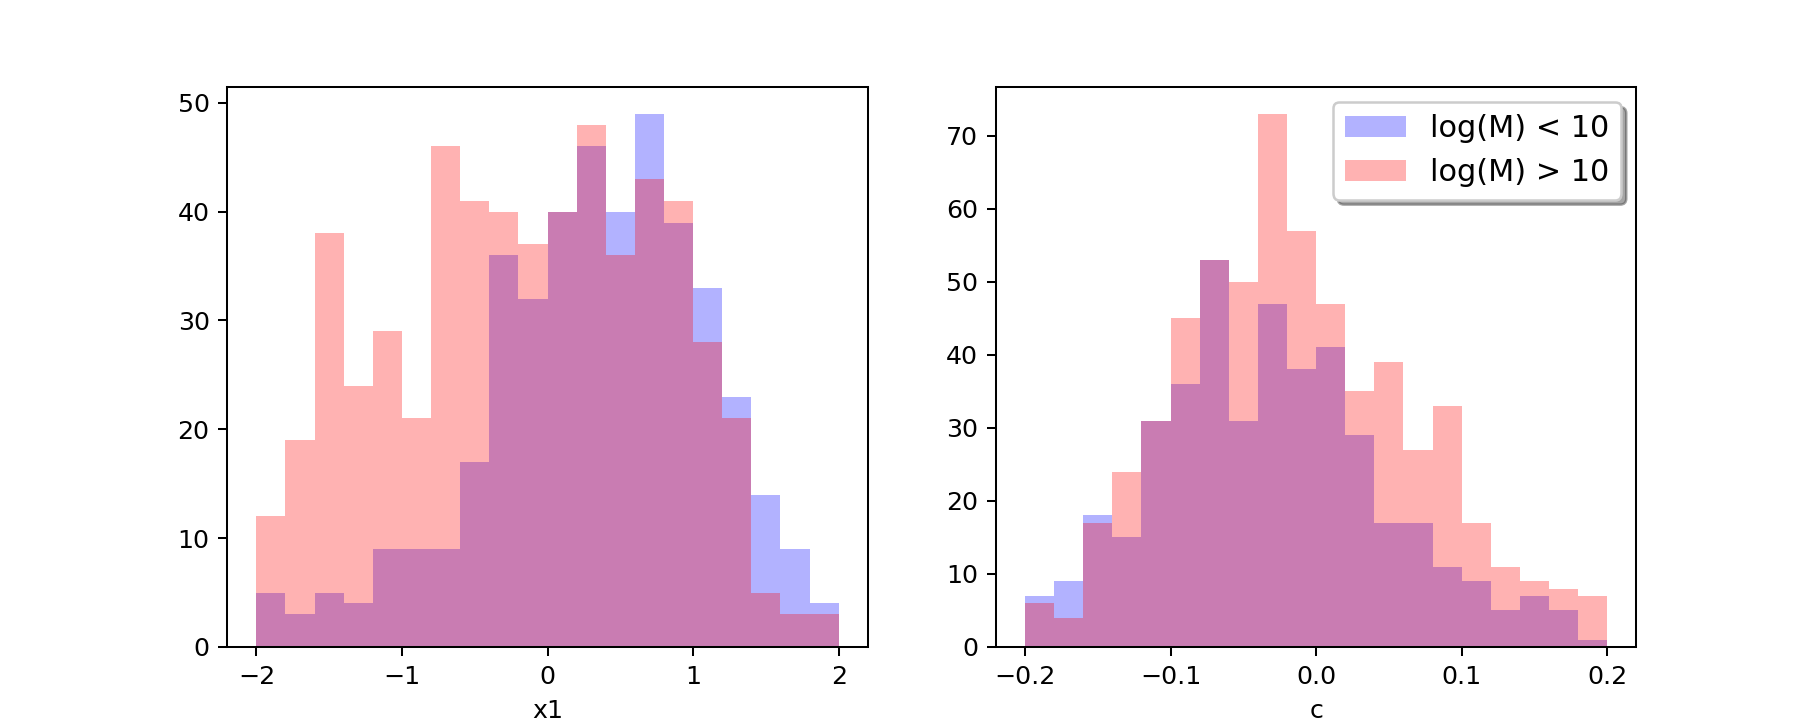

In [14]:
# M_st vs x1, c
Mlow = SNdata['HOST_LOGMASS'] <= 10
Mhigh = SNdata['HOST_LOGMASS'] > 10

fig = plt.figure(figsize=[10,4])
ax  = fig.add_subplot(121)
ax.hist(SNdata['x1'][Mlow], 20, range=[-2,2], color='blue', alpha=0.3, label='log(M) < 10')
ax.hist(SNdata['x1'][Mhigh], 20, range=[-2,2], color='red', alpha=0.3, label='log(M) > 10')
ax.set_xlabel("x1")
ax  = fig.add_subplot(122)
ax.hist(SNdata['c'][Mlow], 20, range=[-0.2,0.2], color='blue', alpha=0.3, label='log(M) < 10')
ax.hist(SNdata['c'][Mhigh], 20, range=[-0.2,0.2], color='red', alpha=0.3, label='log(M) > 10')
ax.set_xlabel("c")
ax.legend(loc='best', shadow=True, fontsize='large')
